### Setup

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pickle 
import torch as th
import torch.nn.functional as F
import torch
import networkx as nx
import pandas as pd
import numpy as np

import torch_geometric
from torch_geometric.explain import Explainer, CaptumExplainer, DummyExplainer, GNNExplainer
from torch_geometric.explain.metric import *
from torch_geometric.nn.models.basic_gnn import GraphSAGE
from torch_geometric.utils import from_dgl
from tqdm import tqdm
from torch_geometric.explain import ModelConfig

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [2]:
import dgl
import numpy as np

def get_batch(data):
    all_data = data.copy()
    while len(all_data) > 0:
        if len(all_data) >= 5000:
            batch = all_data.sample(5000)
            all_data = all_data.drop(batch.index)
            yield batch
        else:
            batch = all_data.copy()
            all_data = all_data.drop(batch.index)
            yield batch

def to_graph(data):
    G = nx.from_pandas_edgelist(data, source='src', 
                                target='dst', 
                                edge_attr=['x', 'Attack'], 
                                create_using=nx.MultiGraph())
    
    G = G.to_directed()
    # NOTE paper also uses 'i' index for each node as an identifier
    g = dgl.from_networkx(G, edge_attrs=[ 'x', 'Attack'])
    g = g.line_graph(shared=True)
    return from_dgl(g) 

def fidelity(pred_orig, pred_masked, y):
    return  (
        np.array(pred_orig == y, dtype=int) - np.array(pred_masked == y, dtype=int)
    ).mean()


/home/taznk/COMP4003/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
test = pd.read_csv('interm/BoT_test.csv')
attrs = [c for c in test.columns if c not in ("src", "dst", "Attack", "x")]
test['x'] = test[attrs].values.tolist()
len(test['x'][0])


49

In [4]:
def load_model():
    model = GraphSAGE(
        49,
        hidden_channels=256,
        out_channels=5,
        num_layers=3,
    ).to(device)

    model.load_state_dict(th.load('interm/GraphSAGE_BoTIoT.pth'))
    model.eval()
    return model

model = load_model()

/tmp/ipykernel_157363/881949505.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(th.load('interm/GraphSAGE_BoTIoT.pth'))


In [5]:
G = to_graph(test)

In [6]:
from sklearn.metrics import classification_report

y_pred = model(G.x, G.edge_index)
y_pred = y_pred = torch.argmax(y_pred, dim=1)
y_true = G.Attack

print(
    classification_report(y_true, y_pred)
)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     22668
           1       0.72      0.79      0.75      2156
           2       0.76      0.68      0.72      2108
           3       0.99      0.91      0.95      2096
           4       1.00      1.00      1.00       732

    accuracy                           0.96     29760
   macro avg       0.89      0.88      0.88     29760
weighted avg       0.96      0.96      0.96     29760



### DummyExplainer

In [39]:
explainer = Explainer(
    model=model,
    algorithm=DummyExplainer(),
    # explanation_type='model',
    explanation_type='phenomenon',
    node_mask_type='attributes',
    edge_mask_type=None,
    model_config=ModelConfig(
        mode='multiclass_classification',
        task_level='node',
        return_type='raw',
    ),
)  
explanation = explainer(
        x=G.x.to(device),
        edge_index=G.edge_index.to(device),
        target=G.Attack,
)

In [40]:
import copy
from torch_geometric.explain.metric import fidelity, characterization_score

explanation_cp = copy.deepcopy(explanation)

de_metrics = {'fid+': [], 'fid-': [], 's': [], 'c': [], 'k': []}

## Top K features 
for s in tqdm(np.arange(0.1, 1, 0.1)):
    
    flat_mask = explanation.node_mask.flatten()
    k = int(s * flat_mask.numel())
    threshold = torch.topk(flat_mask, k).values[-1]
    
    new_mask = (explanation.node_mask >= threshold).float()
    explanation_cp.node_mask = new_mask
    
    fp, fn = fidelity(explainer, explanation_cp)
    de_metrics['fid+'].append(fp)
    de_metrics['fid-'].append(fn)
    
    c = characterization_score(fp, fn) if (fp * fn) != 0 else 0
    de_metrics['c'].append(c)
    de_metrics['s'].append(s)
    de_metrics['k'].append(k)

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [01:09<00:00,  7.77s/it]


### GNNExplainer

In [14]:
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(100),
    # explanation_type='model',
    explanation_type='phenomenon',
    node_mask_type='attributes',
    edge_mask_type=None,
    model_config=ModelConfig(
        mode='multiclass_classification',
        task_level='node',
        return_type='raw',
    ),
)  
explanation = explainer(
        x=G.x.to(device),
        edge_index=G.edge_index.to(device),
        target=G.Attack,
)

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [01:10<00:00,  7.82s/it]


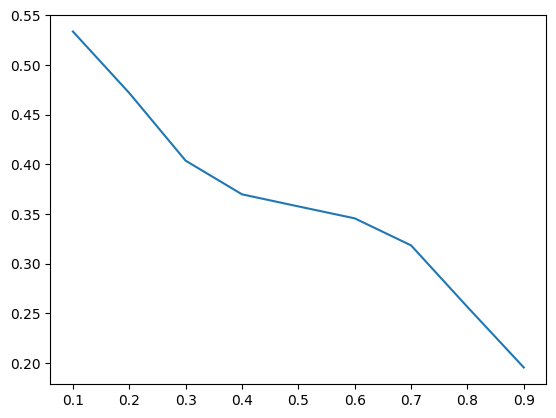

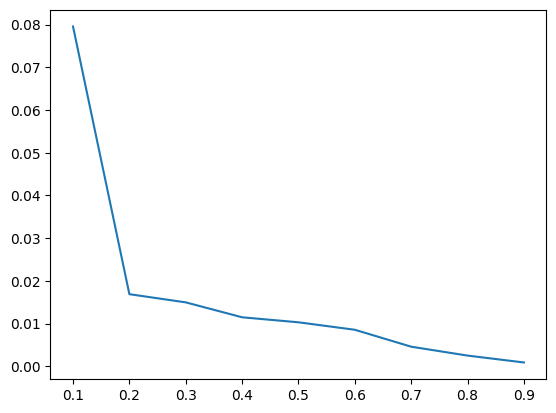

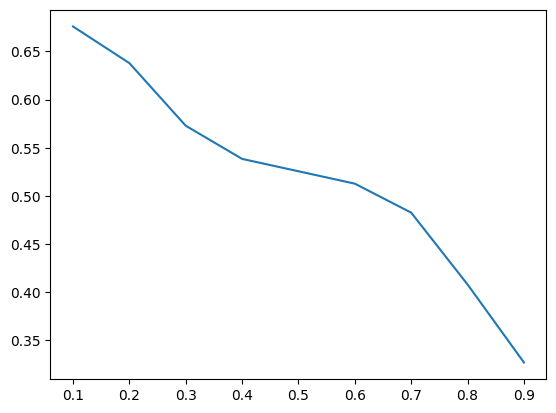

In [ ]:
import copy
from torch_geometric.explain.metric import fidelity, characterization_score

explanation_cp = copy.deepcopy(explanation)

gnne_metrics = {'fid+': [], 'fid-': [], 's': [], 'c': [], 'k': []}

## Top K features 
for s in tqdm(np.arange(0.1, 1, 0.1)):
    
    flat_mask = explanation.node_mask.flatten()
    k = int(s * flat_mask.numel())
    threshold = torch.topk(flat_mask, k).values[-1]
    
    new_mask = (explanation.node_mask >= threshold).float()
    explanation_cp.node_mask = new_mask
    
    fp, fn = fidelity(explainer, explanation_cp)
    gnne_metrics['fid+'].append(fp)
    gnne_metrics['fid-'].append(fn)
    
    c = characterization_score(fp, fn) if (fp * fn) != 0 else 0
    gnne_metrics['c'].append(c)
    gnne_metrics['s'].append(s)
    gnne_metrics['k'].append(k)
   
   

In [38]:
gnne_metrics['s'], gnne_metrics['fid+'], gnne_metrics['fid-'], gnne_metrics['c']

([np.float64(0.1),
  np.float64(0.2),
  np.float64(0.30000000000000004),
  np.float64(0.4),
  np.float64(0.5),
  np.float64(0.6),
  np.float64(0.7000000000000001),
  np.float64(0.8),
  np.float64(0.9)],
 [0.5338709950447083,
  0.4719422161579132,
  0.4037970304489136,
  0.3699260652065277,
  0.35776209831237793,
  0.34573253989219666,
  0.31851479411125183,
  0.25651881098747253,
  0.19559812545776367],
 [0.07956989109516144,
  0.01686828024685383,
  0.014952956698834896,
  0.01145833358168602,
  0.010282258503139019,
  0.008534946478903294,
  0.004569892305880785,
  0.002486559096723795,
  0.0008736558957025409],
 [0.6757760642216811,
  0.6377426619286249,
  0.57279154435744,
  0.5383820615502408,
  0.5255492297161668,
  0.5126867306023583,
  0.48260656191700535,
  0.4080931115108564,
  0.3271503095168128])

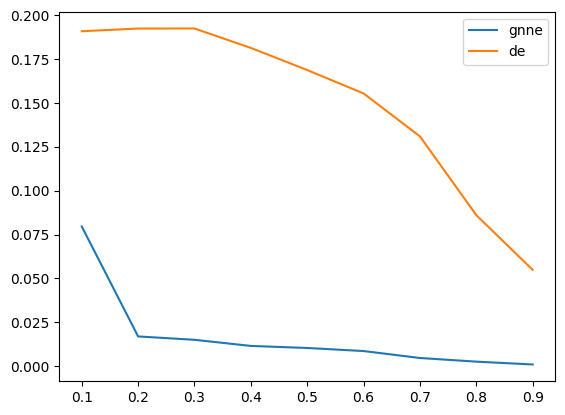

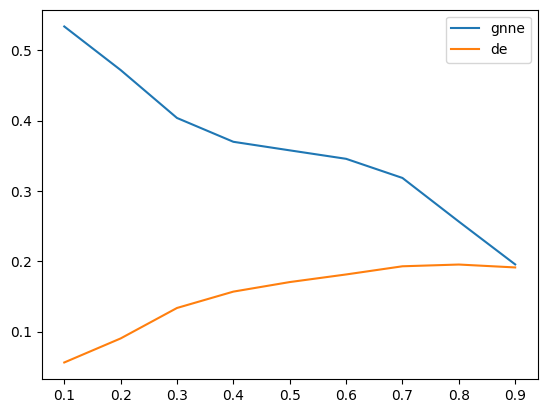

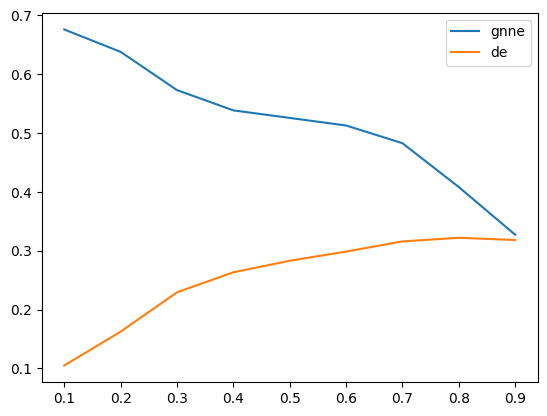

In [44]:
plt.plot(gnne_metrics['s'], gnne_metrics['fid-'])
plt.plot(de_metrics['s'], de_metrics['fid-'])
plt.legend(('gnne', 'de'))
plt.show()

plt.plot(gnne_metrics['s'], gnne_metrics['fid+'])
plt.plot(de_metrics['s'], de_metrics['fid+'])
plt.legend(('gnne', 'de'))
plt.show()

plt.plot(gnne_metrics['s'], gnne_metrics['c'])
plt.plot(de_metrics['s'], de_metrics['c'])
plt.legend(('gnne', 'de'))

### IntegratedGradients

In [46]:
import torch
from tqdm import tqdm

def integrated_gradients(x, edge_index, model, baseline, steps):
    device = x.device
    if baseline is None:
        baseline = torch.zeros_like(x, device=device)

    diff = x - baseline
    total_grads = torch.zeros_like(x, device=device)

    for alpha in tqdm(torch.linspace(0.0, 1.0, steps, device=device)):
        x_scaled = baseline + alpha * diff
        x_scaled.requires_grad_(True)

        # forward pass
        out = model(x_scaled, edge_index)
        
        # pick the logit for each root node & assume root nodes are first B rows
        # batch_size = targets.size(0)
        # sel = out[:batch_size, :] 
        # chosen = sel[torch.arange(batch_size), targets]

        # sum to get a scalar and backprop
        model.zero_grad()
        torch.autograd.backward(out.sum(), retain_graph=True)
        grads = x_scaled.grad

        total_grads += grads
        x_scaled.grad.zero_()

    # average gradient then scale by input delta
    avg_grads = total_grads / steps
    attributions = diff * avg_grads 

    return attributions


model.eval()
ig_attr = integrated_gradients(
    x=G.x,
    edge_index=G.edge_index,
    # targets=targets,
    model=model,
    baseline=torch.zeros_like(G.x),
    steps=100
)


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [06:51<00:00,  4.11s/it]


In [48]:
ig_attr.shape

torch.Size([29760, 49])

In [ ]:
import copy
from torch_geometric.explain.metric import fidelity, characterization_score

ig_metrics = {'fid+': [], 'fid-': [], 's': [], 'c': [], 'k': []}


def manual_fidelities(mask):
    y_pred = model(G.x, G.edge_index).argmax(axis=1)
    ym_pred = model(G.x*mask, G.edge_index).argmax(axis=1)
    ymi_pred = model(G.x*(~mask), G.edge_index).argmax(axis=1)
    y = G.Attack
    
    # fid_plus = (np.array(y_pred == y, dtype=int) - np.array(ym_pred == y, dtype=int)).mean() 
    # fid_minus = (np.array(y_pred == y, dtype=int) - np.array(ymi_pred == y, dtype=int)).mean() 
    pos_fidelity = ((y_pred == y).float() -
                        (ymi_pred == y).float()).abs().mean()
    neg_fidelity = ((y_pred == y).float() -
                        (ym_pred == y).float()).abs().mean()
        
    return pos_fidelity, neg_fidelity
    

mx, mn = ig_attr.max(), ig_attr.min()
ig_soft_mask = (ig_attr - mn) / (mx + mn)

## Top K features 
for s in tqdm(np.arange(0.1, 1, 0.1)):
    
    flat_mask = ig_soft_mask.flatten()
    k = int(s * flat_mask.numel())
    threshold = torch.topk(flat_mask, k).values[-1]
    
    hard_mask = (ig_soft_mask >= threshold).bool()
    fp, fn = manual_fidelities(hard_mask)
    
    ig_metrics['fid+'].append(fp)
    ig_metrics['fid-'].append(fn)
    
    c = characterization_score(fp, fn) if (fp * fn) != 0 else 0
    ig_metrics['c'].append(c)
    ig_metrics['s'].append(s)
    ig_metrics['k'].append(k)
   

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [01:09<00:00,  7.76s/it]


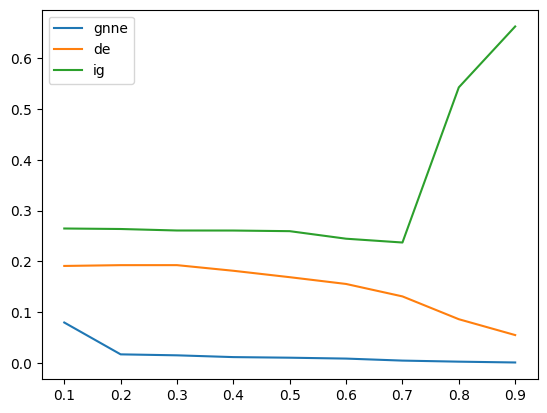

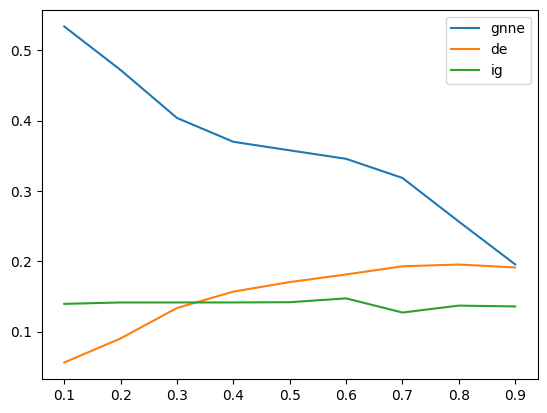

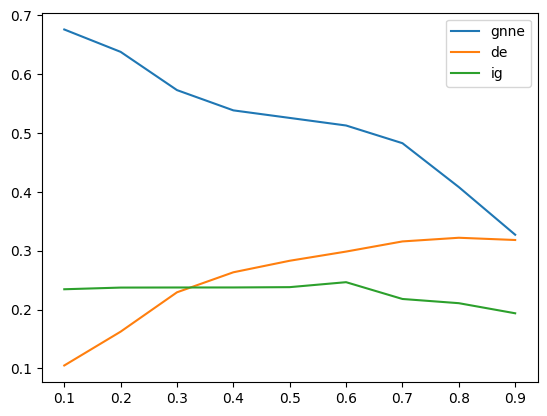

In [78]:
plt.plot(gnne_metrics['s'], gnne_metrics['fid-'])
plt.plot(de_metrics['s'], de_metrics['fid-'])
plt.plot(ig_metrics['s'], ig_metrics['fid-'])
plt.legend(('gnne', 'de', 'ig'))
plt.show()

plt.plot(gnne_metrics['s'], gnne_metrics['fid+'])
plt.plot(de_metrics['s'], de_metrics['fid+'])
plt.plot(ig_metrics['s'], ig_metrics['fid+'])
plt.legend(('gnne', 'de', 'ig'))
plt.show()

plt.plot(gnne_metrics['s'], gnne_metrics['c'])
plt.plot(de_metrics['s'], de_metrics['c'])
plt.plot(ig_metrics['s'], ig_metrics['c'])
plt.legend(('gnne', 'de', 'ig'))

### GraphMask

In [7]:
from torch_geometric.explain.algorithm import GraphMaskExplainer

model_config = ModelConfig(
    mode='multiclass_classification',
    task_level='node',
    return_type='raw'
)

explainer = Explainer(
    model=model,
    algorithm=GraphMaskExplainer(2),
    explanation_type='model',
    model_config=model_config,
    node_mask_type='object'
)


In [ ]:
# ! instant mem overflow -> rea paper and consider batching 
explanation = explainer(G.x, G.edge_index)


: 

### PGExplainer

In [ ]:
import psutil, os, gc
proc = psutil.Process(os.getpid())

def cpu_mem(tag=""):
    gc.collect()
    rss = proc.memory_info().rss / 1024**2
    print(f"[{tag}] RSS={rss:.1f}MB")

In [ ]:
from torch_geometric.explain import Explainer, ModelConfig
from torch_geometric.explain.algorithm import PGExplainer
from torch_geometric.utils import k_hop_subgraph
import torch, gc

model.eval()
for p in model.parameters():
    p.requires_grad_(False)

model_config = ModelConfig(
    task_level='node',
    mode='multiclass_classification',
    return_type='probs',
)

explainer = Explainer(
    model=model,
    algorithm=PGExplainer(epochs=30, lr=0.003),
    explanation_type='phenomenon',
    edge_mask_type='object',  # consider reducing subgraph radius if this is big
    model_config=model_config,
)

target_node = 0
subset, sub_edge_index, mapping, _ = k_hop_subgraph(
    target_node, num_hops=2, edge_index=G.edge_index, relabel_nodes=True
)
x_sub = G.x[subset]
y_sub = G.Attack[subset] if G.Attack.ndim > 0 else G.Attack
target_idx = mapping.item()

for epoch in range(30):
    loss = explainer.algorithm.train(
        epoch, model, x_sub, sub_edge_index, target=y_sub, index=target_idx
    )
    # Avoid keeping any graph around:
    loss_value = float(loss)   # .item() equivalent, detaches and frees the graph
    del loss
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# Generate explanation on the same subgraph
explanation = explainer(x=x_sub, edge_index=sub_edge_index, 
                        target=y_sub, index=target_idx)




tensor([1.6135e-07, 1.8181e-27, 1.3879e-27,  ..., 1.6523e-12, 2.1867e-12,
        2.1867e-12])


AttributeError: 'GlobalStorage' object has no attribute 'node_mask'